Drive

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Libraries

In [16]:
import pandas as pd
import os
from skimage.transform import resize
from skimage.io import imread
from skimage import color
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
from skimage.feature import local_binary_pattern
from sklearn import preprocessing, metrics
from sklearn.svm import LinearSVC
import urllib.request
from PIL import Image, ImageOps
from pathlib import Path

LBP

In [17]:
# params
radius = 3
n_points = 8 * radius
n_bins = n_points + 2

In [18]:
def compute_lbp(lbp):
  # Vectorization/Normalization to get feature vector.
  lbp = lbp.ravel()
  feature = np.zeros(n_bins)
  for i in lbp:
    feature[int(i)] += 1
  feature /= np.linalg.norm(feature, ord=1)
  return feature

Preprocessing

In [19]:
Categories=['disgust','happy','contempt']

In [20]:
target_arr=[] #output array
vec=[] #features array
cascade_classifier = cv2.CascadeClassifier('/content/drive/My Drive/Colab Notebooks/haarcascade_frontalface_alt.xml')
# CK+
datadir='/content/drive/My Drive/Colab Notebooks/dataset/'
#path which contains all the categories of images
for i in Categories:
    path=os.path.join(datadir,i)
    for img in os.listdir(path):
      if (os.path.join(path,img).endswith('.png')):
        url = os.path.join(path,img)
        img_array = np.array(Image.open(url).convert('L'))
        # violajones
        detected_faces = cascade_classifier.detectMultiScale(img_array, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))
        # crop
        if (len(detected_faces)!=0):
          for (x, y, width, height) in detected_faces:
            image = img_array[y:y + height,x:x + width]
        else:
          image = img_array
        img_resized=resize(image,(512,384))
        # Find LBP of all pixels
        lbp = local_binary_pattern(img_resized, n_points, radius, 'uniform')
        feature = compute_lbp(lbp)
        vec.append(feature)
        target_arr.append(Categories.index(i))

Original Image :


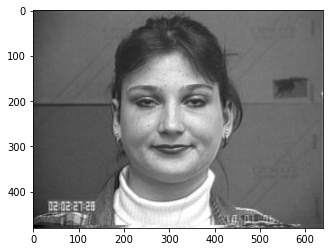

ViolaJones Output :


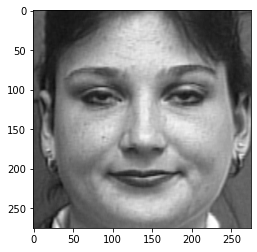

LBP Output :


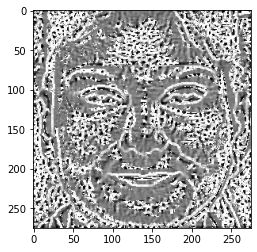

In [21]:
print("Original Image :")
img=imread(url,as_gray=True)
plt.imshow(img,cmap='gray')
plt.show()
print("ViolaJones Output :")
plt.imshow(image,cmap='gray')
plt.show()
lbp = local_binary_pattern(image, n_points, radius, 'uniform')
print("LBP Output :")
plt.imshow(lbp,cmap='gray')
plt.show()

In [22]:
target=np.array(target_arr)
df=pd.DataFrame(vec) #dataframe
df['Target']=target
x=df.iloc[:,:-1] #input data 
y=df.iloc[:,-1] #output data

SVM

In [23]:
from sklearn.svm import SVC
svc = SVC(kernel='poly', degree=8 ,probability=True)

Train

In [24]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)
svc.fit(x_train,y_train)

SVC(degree=8, kernel='poly', probability=True)

Test and Accuracy

In [25]:
from sklearn.metrics import accuracy_score
y_pred=svc.predict(x_test)
print("The predicted Data is :")
print(y_pred)
print("The actual data is:")
print(np.array(y_test))
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")

The predicted Data is :
[1 1 1 1 0 0 0 1 1 0 2 2 1 1 1 0 1 1 1 0 0 1 0 1 0 1 1 0 2 2]
The actual data is:
[1 1 1 1 0 0 0 0 1 0 2 2 0 1 0 0 1 1 1 1 0 0 0 1 1 1 1 0 2 2]
The model is 80.0% accurate


Depression Level Detection

In [26]:
datadir='/content/drive/My Drive/Colab Notebooks/dataset/sequences/'
PredictedLevel = []
ActualLevel = ['high','high','high','high','high','none','mild','high(concealed)','none','mild']

#path which contains all the categories of images
for i in range (1,11):
  seq = [] #sequences array
  neg = 0
  pos = 0
  path=os.path.join(datadir,str(i))
  for img in os.listdir(path):
    if (os.path.join(path,img).endswith('.jpg') or os.path.join(path,img).endswith('.png')):
      img_array = np.array(Image.open(os.path.join(path,img)).convert('L'))
      detected_faces = cascade_classifier.detectMultiScale(img_array, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))
      # crop
      if (len(detected_faces)!=0):
        for (x, y, width, height) in detected_faces:
          image = img_array[y:y + height,x:x + width]
      else:
        image = img_array
      img_resized=resize(image,(512,384))
      lbp = local_binary_pattern(img_resized, n_points, radius, 'uniform')
      feature = compute_lbp(lbp)
      L=feature.reshape(1, -1)
      if (Categories[svc.predict(L)[0]]=='happy'):
        seq.append('pos')
        pos = pos +1
      else:
        seq.append('neg')
        neg = neg +1
  DepressionLevel = 'none'
  if (neg>= 0.4*len(seq) and pos>=0.4*len(seq)):
    DepressionLevel = 'high(concealed)'
  elif (neg>= 0.4*len(seq) and pos<=0.26*len(seq)):
    DepressionLevel = 'high' 
  elif (neg>= 0.4*len(seq) and (pos>=0.33*len(seq) or pos<=0.4*len(seq))):
    DepressionLevel = 'mild'
  PredictedLevel.append(DepressionLevel)
  print(str(i)+" : " + str(seq))

1 : ['neg', 'neg', 'neg', 'neg', 'neg', 'pos']
2 : ['pos', 'neg', 'neg', 'neg', 'pos', 'pos']
3 : ['neg', 'neg', 'neg', 'neg', 'neg', 'neg']
4 : ['neg', 'neg', 'neg', 'neg', 'neg', 'neg']
5 : ['neg', 'neg', 'neg', 'neg', 'pos', 'pos']
6 : ['pos', 'pos', 'pos', 'pos', 'pos', 'pos']
7 : ['neg', 'pos', 'pos', 'neg', 'pos', 'pos']
8 : ['neg', 'pos', 'neg', 'pos', 'pos', 'neg']
9 : ['pos', 'pos', 'pos', 'neg', 'pos', 'pos']
10 : ['pos', 'neg', 'neg', 'pos', 'neg', 'neg']


In [27]:
print("The predicted depression level is :")
print(PredictedLevel)
print("The actual depression level is:")
print(ActualLevel)
print(f"The accuracy is {accuracy_score(PredictedLevel,ActualLevel)*100}%.")

The predicted depression level is :
['high', 'high(concealed)', 'high', 'high', 'mild', 'none', 'none', 'high(concealed)', 'none', 'mild']
The actual depression level is:
['high', 'high', 'high', 'high', 'high', 'none', 'mild', 'high(concealed)', 'none', 'mild']
The accuracy is 70.0%.


Comarison Plot

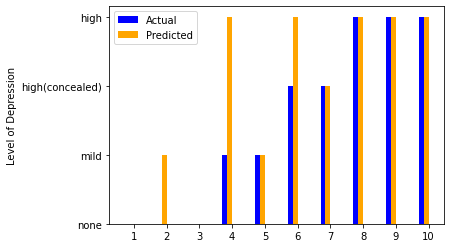

In [28]:
index = [4,3,4,4,2,1,1,3,1,2]
df = pd.DataFrame(
    {'index' : index,
     'Actual': PredictedLevel,
     'Predicted': ActualLevel
    })
dff=df.sort_values('index')

# Create a Figure with one Axis on it
fig, ax = plt.subplots()
# The x-values of the bars.
x = np.arange(1,11)
# The width of the bars
width = 0.15
# Create the bar charts
ax.bar(x - 3*width/2, dff['Actual'], width, label='Actual', color='blue')
ax.bar(x - width/2, dff['Predicted'], width, label='Predicted', color='orange')

# Notice that features like labels and titles are added in separate steps
ax.set_ylabel('Level of Depression')
# ax.set_title('Dataset')

ax.set_xticks(x)    # all datasets as y

ax.legend()
plt.show()
